In [60]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.5em; }
</style>

In [61]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
from scipy import fftpack
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams, patches
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='500px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

### Universidad Austral de Chile 

## INFO183: Análisis de sistemas lineales

# Unidad 3: Sistemas para el procesamiento de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Definición de sistema](#section1)
1. Sistemas lineales e invariantes en el tiempo

# Definición de sistema


- *Análisis de señales:* El estudio de las señales y sus propiedades en el dominio del tiempo y frecuencia
- *Procesamiento de señales:* El diseño de **sistemas** que procesan **señales de entrada** y producen **señales de salida**
    - Adicionalmente, un sistema puede tener parámetros (entradas númericas o booleanas)
    - Adicionalmente, un sistema puede tener retornos (salidas númericas o booleanas)
    - Sistema sin señal de entrada: Oscilador
    - Sistema sin señal de salida: Detector/clasificador de señal
    - Existen sistemas analógicos (continuos) y digitales (discretos), nos enfocaremos en los últimos
    
   
<center><img src="img/system.png"></center>

- Usaremos $x[n]$ para denotar la señal (discreta) de entrada y $X[k]$ su espectro
- Usaremos $y[n]$ para denotar la señal (discreta) de salida e $Y[k]$ su espectro
 


1. Un sistema para reducir el ruido de una EEG
<center><img src="img/system-denoise-eeg.png"></center>
1. Un sistema para mejorar (sharpen) una imagen fuera de foco
<center><img src="img/system-sharpen.jpg"></center>
1. Un sistema para eliminar el eco de un audio
<center><img src="img/system-echo.png"></center>


# Sistemas  sin memoria

Los sistemas sin memoria son de forma
$$
y[n] = f(x[n]),
$$
es decir la salida del sistema en un instante dado depende solo de la entrada en ese instante

### Ejemplos


- Sistema amplificador ideal 
$$
y[n] = A x[n], 
$$
donde $A$ se llama *ganancia*
    - provoca atenuación de la entrada si $A<1$
    - es un sistema identidad si $A=1$

- Sistema con corrupción cuadrática
$$
y_n = x_n + \epsilon x_n^2
$$

- Sistema saturador
$$
y_n = \text{sign}(x_n)
$$
- Sistema rectificador
$$
y_n = | x_n |
$$

<IPython.core.display.Javascript object>


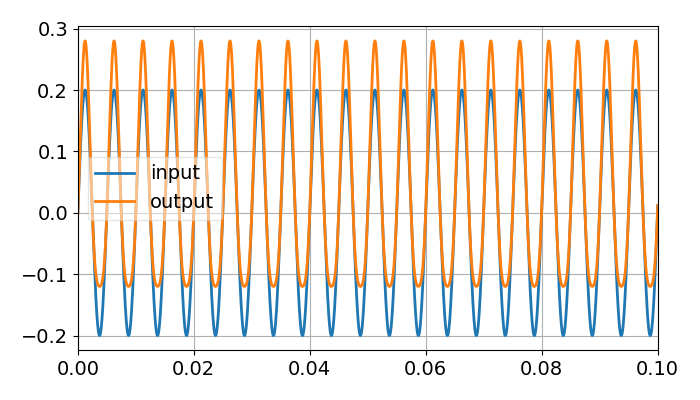

In [70]:
fig, ax = plt.subplots(figsize=(7, 4))
Fs = 22050
n = np.arange(0, 2, step=1.0/Fs)
x = 0.2*np.sin(2.0*np.pi*200*n); 
y = x + 2*x**2
ax.plot(n, x, label='input'); ax.plot(n, y, label='output'); 
ax.set_xlim([0, 0.1]); plt.legend()
Audio(np.concatenate((y, [1, -1])), rate=Fs)

# Sistema Lineal

Propiedades de los sistemas lineales

- **Homogeneidad:** Un cambio en la amplitud de la entrada produce un cambio equivalente en la salida

$$
f(cx[n]) = c f(x[n]) = c y[n]
$$

- **Aditividad:** Señales que se suman en la entrada producen señales que se suman en la salida

$$
f(x_1[n] + x_2[n]) = f(x_1[n]) + f(x_2[n]) = y_1[n] + y_2[n]
$$

    - Las señales pasan por el sistema sin interactuar entre ellas
- Si no se cumple alguna de estas propiedades el sistema es **no lineal**
- ¿Son los sistemas anteriores lineales?

# Ejemplos de sistemas con memoria

Un sistemas con memoria es aquel cuya salida puede depender de 
- la entrada actual
- las entradas anteriores
- las salidas anteriores

$$
y[n] = f(x[n], x[n-1], \ldots, x[0], y[n-1], y[n-2], \ldots y[0]),
$$

### Ejemplo

- Sistema con retardo (delay)

$$
y[n] = x[n-m],
$$
    - depende solo de una entrada "pasada"
    - el valor de m define que tan "antigua" es la entrada pasada

- Sistema reverberador (eco)

$$
y[n] = x[n] + A x[n-m],
$$

    - depende de una entrada "pasada" y la entrada actual
    - la ganancia controla si el eco es atenuado o amplificado

# Sistema invariante en el tiempo o invariante al desplazamiento

Un sistema es invariante al desplazamiento temporal (*shift-invariant*) si la operación que realiza no depende del tiempo

$$
f(x[n-m]) = y[n-m] 
$$

Es decir que si aplicamos un retardo en la entrada se traduce en un retardo de la salida

- ¿Son los sistemas anteriores invariantes al desplazamiento?

# Sistema LTI 

Los sistemas LTI (*linear time-invariant*) son lineales e invariantes al desplazamiento temporal

## Sistema FIR 

Generalizando el ejemplo de sistema reverberante a más retardos llegamos a 

$$
\begin{align}
y[n] &= h_0 x[n] + h_1 x[n-1] + h_2 x[n-2] + \ldots + h_{L} x[n-L] \nonumber \\
&= \sum_{j=0}^{L} h_j x[n-j] \nonumber \\
&= h* x[n] \nonumber 
\end{align}
$$

que se puede modelar como una convolución discreta o en pseuco-código como un ciclo iterativo
```
   y[n] = 0
   for j in 0 to L
       y[n] = y[n] + h_j x[n-j]
```
y se conoce como


- sistema FIR (finite impulse response)
- sistema MA (moving average)
- sistema todo-zeros 

y es de orden L (posee L+1 coeficientes)

- ¿Es este sistema lineal?
- ¿Que ocurre si entra al sistema un impulso unitario?

# Sistemas retro-alimentados

## Respuesta al impulso

Sea el impulso unitario o delta de Kronecker
$$
\delta[n-m] = \begin{cases} 1 & n=m \\ 0 & n \neq m \end{cases}
$$

La **respuesta al impulso de un sistema discreto** es la salida obtenida cuando la entrada es un impulso unitario

Para el sistema FIR tenemos

$$
y[n] = h * \delta[n] = \sum_{j=0}^L h_j \delta[n-j] = \begin{cases} h_n & n \in [0, L] \\ 0 & \text{en otro caso} \end{cases} \\
$$

es decir la respuesta al impulso tiene una duración finita y luego decae a zero

Notemos que La respuesta al impulso recupera los coeficientes del sistema


## Sistema IIR (infinite impulse response)

Generalizando el ejemplo de sistema FIR para incluir versiones pasadas de la salida llegamos a 

$$
\begin{align}
y[n] &= a_0 x[n] + a_1 x[n-1] + a_2 x[n-2] + \ldots + a_{L} x[n-L]  \nonumber \\
& + b_1 y[n-1] + b_2 y[n-2] + \ldots + b_M y[n-M] \nonumber \\
&= \sum_{j=0}^{L} a_j x[n-j] + \sum_{j=1}^{M} b_j y[n-j]  \nonumber 
\end{align}
$$

que se puede modelar como dos convoluciones discretas


- sistema IIR (infinite impulse response)
- sistema ARMA (auto-regresive moving average)

y es de orden L (posee L+1 coeficientes)

- ¿Es este sistema lineal?
- ¿Que ocurre si entra al sistema un impulso unitario?

...

***

# Contenidos de la unidad

***

1. Detección y comparación de señales
1. Espectro de potencia y Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener

***
[Volver al índice](#index)

<a id="section1"></a>

# Detección y comparación de señales en el tiempo

***

